In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import time
import cv2
import os

from tqdm import tqdm

In [2]:
# for loading the data
base_path = 'E:/Data/Video_Frame_Interpolation/raw/vimeo_triplet'
train_indices = 'tri_trainlist.txt'
test_indices = 'tri_testlist.txt'

# for saving the data
target_path = 'E:/Data/Video_Frame_Interpolation/processed/vimeo90k_pytorch'
train_result_indices = 'train.txt'
test_result_indices = 'test.txt'
valid_result_indices = 'valid.txt'
result_subdir = 'data'

# parameters
train_size = 50000
test_size = 3000
valid_size = 1000
size =  (256, 144)
interpolation = cv2.INTER_CUBIC

## Preprocessing functions

In [3]:
def preprocess(img, size, interpolation):
    img = cv2.resize(img, size, interpolation=interpolation)
    return (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0).astype('float32')

In [4]:
def create_paths(file_path, limit=None, split=None):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    postfixes = [line.strip() for line in lines]
    random.shuffle(postfixes)
    if limit is not None:
        postfixes = postfixes[0:limit]
        
    if split is not None:
        index = int(len(postfixes) * split)
        return postfixes[0:index], postfixes[index:]
    else:
        return postfixes

In [5]:
def create_binaries(base_path, paths, target_path, target_data_dir, size, interpolation):
    for index, path in tqdm(enumerate(paths)):
        # paths to source and destination
        full_path = os.path.join(base_path, 'sequences', path)
        target_full_path = os.path.join(target_path, target_data_dir, str(index))
        
        # create target path if not exists
        if not os.path.exists(target_full_path):
            os.mkdir(target_full_path)
            
        try:
            # loop over triplets
            for name in ['im1', 'im2', 'im3']:
                # paths to source files and the destination files
                img_path = os.path.join(full_path, f'{name}.png')
                target_img_path = os.path.join(target_full_path, f'{name}')
                
                # is source does not exist then skip it
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"File {img_path} was not found")

                # load and preprocess the file
                img = cv2.imread(img_path)
                img = preprocess(img, size, interpolation)
                
                # save the binary
                with open(target_img_path, 'wb') as bf:
                    bf.write(img.tobytes())
        except FileNotFoundError as e:
            print(f"The following error occurred: {e}")
            
    # return ids of created directories        
    return list(range(0, len(paths)))

In [6]:
def split_ids(target_path, ids, train_filename, train_size, test_filename, test_size, valid_filename, valid_size):
    assert len(ids) >= train_size if train_size is not None else 0 + test_size if test_size is not None else 0 + valid_size if valid_size is not None else 0, "No enough data to split"
    
    # shuffle ids
    random.shuffle(ids)
    
    # split ids and create the files
    start = 0
    for s, f in zip([train_size, test_size, valid_size], [train_filename, test_filename, valid_filename]):
        if s is not None:
            with open(os.path.join(target_path, f), 'w') as file:
                for id_ in ids[start:start+s]:
                    file.write(f"{id_}\n")
            start = start + s

In [7]:
train_paths = create_paths(
    file_path = os.path.join(base_path, train_indices),
    limit = None,
    split = None
)
test_paths = create_paths(
    file_path = os.path.join(base_path, test_indices),
    limit = None,
    split = None
)
paths = train_paths + test_paths

In [8]:
ids = create_binaries(
    base_path = base_path, 
    paths = paths, 
    target_path = target_path, 
    target_data_dir = result_subdir, 
    size = size, 
    interpolation = interpolation
)

54980it [1:12:35, 17.79it/s]

The following error occurred: File E:/Data/Video_Frame_Interpolation/raw/vimeo_triplet\sequences\im1.png was not found


55096it [1:12:45, 12.62it/s]


In [9]:
split_ids(
    target_path = target_path, 
    ids = ids, 
    train_filename = train_result_indices, 
    train_size = train_size, 
    test_filename = test_result_indices, 
    test_size = test_size, 
    valid_filename = valid_result_indices, 
    valid_size = valid_size
)

## Example of reading the data

In [10]:
def load_img(path):
    with open(path, 'rb') as bf:
        img_bytes = bf.read()
        return np.reshape(np.frombuffer(img_bytes, dtype='float32'), (size[1], size[0], 3))

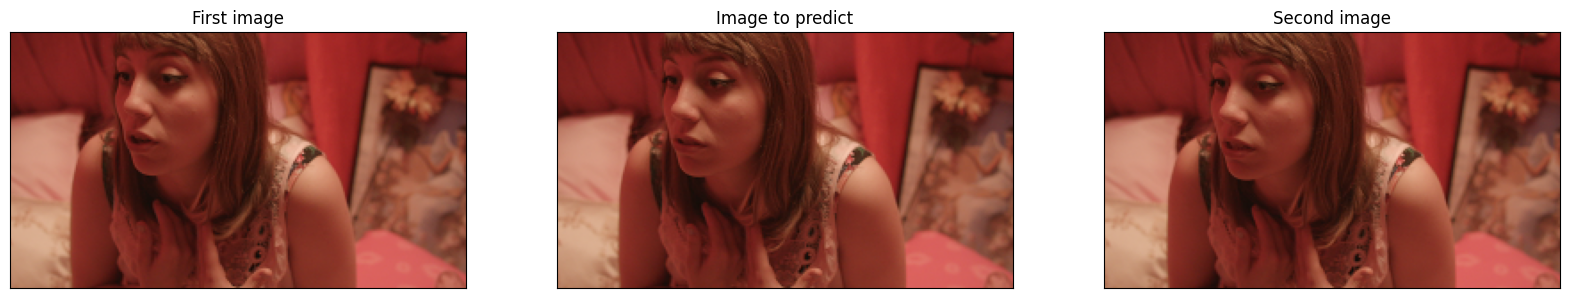

In [11]:
imgs = [
    load_img(os.path.join(target_path, result_subdir, str(ids[0]), 'im1')), 
    load_img(os.path.join(target_path, result_subdir, str(ids[0]), 'im3'))
]
true = load_img(os.path.join(target_path, result_subdir, str(ids[0]), 'im2'))

f, ax = plt.subplots(1, 3)
f.set_size_inches(20, 20)
ax[0].imshow(imgs[0])        
ax[0].set_title('First image')     
ax[0].set_xticks([])     
ax[0].set_yticks([])     
ax[1].imshow(true)   
ax[1].set_title('Image to predict')     
ax[1].set_xticks([])     
ax[1].set_yticks([])    
ax[2].imshow(imgs[1])
ax[2].set_title('Second image') 
ax[2].set_xticks([])     
_ = ax[2].set_yticks([])    